In [1]:
import os
from matplotlib import pyplot as plt

path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
%matplotlib inline

import tensorflow as tf
from bat_snake_env import BatSnake_base
import numpy as np

from tf_agents.agents.dqn import dqn_agent

from tf_agents.environments import tf_py_environment

from tf_agents.policies import random_tf_policy
from tf_agents.networks import sequential
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform, Constant, VarianceScaling


In [2]:
py_env = BatSnake_base(preset=11, time_limit=100, max_level=0)
env = tf_py_environment.TFPyEnvironment(py_env)

In [3]:
fc_layer_params = (128, 128, 128, 64)
action_tensor_spec = tensor_spec.from_spec(py_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    dense_net  = tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
    return dense_net

In [4]:
dense_net = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = Dense(
    num_actions,
    kernel_initializer=RandomUniform(
        minval=-0.05, maxval=0.05),
    bias_initializer=Constant(-0.2))
q_net = sequential.Sequential(dense_net + [q_values_layer])

In [5]:
num_iterations = 2_500_000

initial_collection_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 500_000

batch_size = 1024
learning_rate = 1e-4
log_interval = 5000

num_eval_episodes = 10
eval_interval = 10000

epsilon = 0.8


In [6]:
eval_py_env = BatSnake_base(preset=11, time_limit=100, max_level=0)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy = epsilon,
    gamma = 0.999,
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [8]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0
    cache = []
    for episode in range(num_episodes):
        time_step = environment._reset()
        episode_return = 0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment._step(action_step.action)
            episode_return += time_step.reward
        else:
            #print('ep={0}, return={1}'.format(episode, episode_return.numpy()[0]))
            total_return += episode_return
            cache.append(episode_return.numpy()[0])
    avg_return = total_return/num_episodes
    return avg_return.numpy()[0], cache

In [10]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)

In [11]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    
    buffer.add_batch(traj)

In [12]:
def collect_data(environment, policy, buffer, steps):
    for _ in range(steps):
        collect_step(environment, policy, buffer)

In [13]:
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(), env.action_spec())
collect_data(env, random_policy, replay_buffer, initial_collection_steps)

In [14]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=8,
    sample_batch_size=batch_size,
    num_steps=2,
    single_deterministic_pass=False).prefetch(8)
iterator = iter(dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [15]:
tf.__version__

'2.4.1'

In [16]:
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)
print('checkpoint 1')
avg_return, _ = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
losses = []
print('checkpoint 2')

for i in range(num_iterations):
    if i== 300_000:
        py_env.update_setting(preset=11, time_limit=1000, max_level=5)
        eval_py_env.update_setting(preset=11, time_limit=1000, max_level=5)
    if i== 600_000:
        py_env.update_setting(preset=1, time_limit=1000, max_level=10)
        eval_py_env.update_setting(preset=1, time_limit=1000, max_level=10)

    collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        losses.append(train_loss)
    if step % eval_interval == 0:
        avg_return, cache = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step= {0}: Avg_Return = {1}'.format(step, avg_return), end=' ')
        for i in cache:
            print('{'+str(i)+'}-',end='')
        print('.')
        returns.append(avg_return)

    if avg_return > 15 and (step % 1000 == 0):
        temp, temp_cache = compute_avg_return(eval_env, agent.policy, 10)
        print(temp)
        print(temp_cache)
        if temp >15:
            break


#print('Final Evaluation over 100 episodes: ')
#avg_100_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes*10)
#print('Average Return over 100 eps = {0}'.format(avg_100_return))

checkpoint 1
checkpoint 2
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 5000: loss = 0.05149373412132263
step = 10000: loss = 0.01784151792526245
step= 10000: Avg_Return = 1.399999976158142 {2.0}-{2.0}-{2.0}-{2.0}-{2.0}-{0.0}-{2.0}-{0.0}-{2.0}-{0.0}-.
step = 15000: loss = 0.029268629848957062
step = 20000: loss = 0.036752715706825256
step= 20000: Avg_Return = 1.0 {0.0}-{2.0}-{0.0}-{2.0}-{-2.0}-{2.0}-{2.0}-{2.0}-{0.0}-{2.0}-.
step = 25000: loss = 0.022410109639167786
step = 30000: loss = 0.034735605120658875
step= 30000: Avg_Return = 1.7999999523162842 {0.0}-{2.0}-{2.0}-{2.0}-{2.0}-{2.0}-{2.0}-{2.0}-{2.0}-{2.0}-.
step = 35000: loss = 0.03699107468128204
step = 40000: loss = 0.03152013570070267
step= 40000: Avg_Return = 1.600000023841858 {2.0}-{2.0}-{2.0}-{2.0}-{2.0}-{0.0}-{2.0}-{2.0}-{2.0}-{0.0}

step = 425000: loss = 0.016141816973686218
step = 430000: loss = 0.016336260363459587
step= 430000: Avg_Return = 8.0 {10.0}-{4.0}-{12.0}-{4.0}-{12.0}-{2.0}-{12.0}-{4.0}-{12.0}-{8.0}-.
step = 435000: loss = 0.01827377639710903
step = 440000: loss = 0.03498676046729088
step= 440000: Avg_Return = 4.400000095367432 {12.0}-{2.0}-{4.0}-{2.0}-{2.0}-{4.0}-{12.0}-{2.0}-{2.0}-{2.0}-.
step = 445000: loss = 0.028972674161195755
step = 450000: loss = 0.03888670355081558
step= 450000: Avg_Return = 10.0 {10.0}-{12.0}-{12.0}-{12.0}-{12.0}-{12.0}-{10.0}-{2.0}-{12.0}-{6.0}-.
step = 455000: loss = 0.017368387430906296
step = 460000: loss = 0.009633852168917656
step= 460000: Avg_Return = 7.199999809265137 {2.0}-{6.0}-{6.0}-{8.0}-{8.0}-{4.0}-{12.0}-{12.0}-{8.0}-{6.0}-.
step = 465000: loss = 0.017866192385554314
step = 470000: loss = 0.014184708707034588
step= 470000: Avg_Return = 7.599999904632568 {8.0}-{0.0}-{12.0}-{4.0}-{8.0}-{12.0}-{12.0}-{12.0}-{6.0}-{2.0}-.
step = 475000: loss = 0.02216472290456295
st

step = 855000: loss = 0.15884718298912048
step = 860000: loss = 2.4484236240386963
step= 860000: Avg_Return = 11.600000381469727 {4.0}-{10.0}-{8.0}-{8.0}-{22.0}-{8.0}-{12.0}-{4.0}-{18.0}-{22.0}-.
step = 865000: loss = 0.14272025227546692
step = 870000: loss = 0.15922249853610992
step= 870000: Avg_Return = 4.800000190734863 {10.0}-{2.0}-{2.0}-{4.0}-{0.0}-{-2.0}-{6.0}-{12.0}-{0.0}-{14.0}-.
step = 875000: loss = 2.3219997882843018
step = 880000: loss = 0.10234804451465607
step= 880000: Avg_Return = 12.800000190734863 {10.0}-{10.0}-{18.0}-{16.0}-{0.0}-{22.0}-{6.0}-{10.0}-{14.0}-{22.0}-.
step = 885000: loss = 3.6920251846313477
step = 890000: loss = 0.8370901346206665
step= 890000: Avg_Return = 12.0 {22.0}-{22.0}-{0.0}-{8.0}-{22.0}-{6.0}-{8.0}-{4.0}-{14.0}-{14.0}-.
step = 895000: loss = 0.11942921578884125
step = 900000: loss = 0.11147744953632355
step= 900000: Avg_Return = 6.599999904632568 {6.0}-{0.0}-{12.0}-{6.0}-{22.0}-{0.0}-{10.0}-{4.0}-{-2.0}-{8.0}-.
step = 905000: loss = 0.1220665127

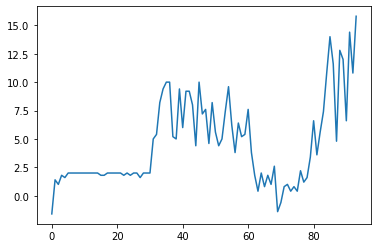

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(returns)

In [18]:
np.max(returns)

15.8

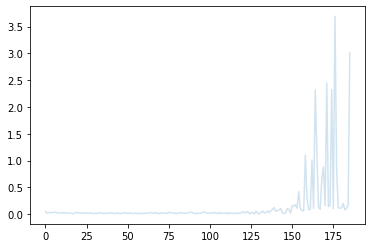

In [19]:
plt.plot(losses, alpha=0.2)

In [ ]:
from coordinate_utils import polar_bat_reference
def check_target(environment, food_k=1):
    food_xyk = environment.obj._coordinates[ environment.obj._coordinates[:,2]==food_k ]
    food_polar = polar_bat_reference(food_xyk, environment.bat._tracker).reshape(2,)
    distance = food_polar[0]
    azimuth = food_polar[1] - environment.bat._tracker[0,2]
    azimuth = (azimuth - 360) if (azimuth>180) else (azimuth + 360) if (azimuth<-180) else azimuth
    #in_range = (distance<(obj.radius[self.diet] + self.harvest_spec['distance_tol'])) and (distance>obj.radius[self.diet])
    #in_view = np.abs(azimuth)<self.harvest_spec['azimuth_tol'
    return distance, azimuth

In [ ]:
eval_py_env.update_setting(preset=1, time_limit=1500, max_level=8, visual=True)

In [ ]:
eval_py_env.update_setting(visual=True)

In [ ]:
step = 0
reward = tf.convert_to_tensor([0.])
time_step = eval_env.reset()
action_decode = eval_py_env.act.decode
action_code_list = list(eval_py_env.act.decode.values())
action_meaning_list = list(eval_py_env.act.decode.keys())
#print('Init Bat @:')
#print(eval_py_env.bat._tracker)
#print('Obj Coordinates:')
#print(eval_py_env.obj._coordinates)
#print('FORMAT: FIGURE SHOW THE ACTIONS THAT IT TOOK THE NEXT STEP.\nTHE THEN TEXT SHOW THE SPECIFIC ACTION, BAT POSITION, AND REWARDS')
while not time_step.is_last():
#for i in range(1):
    action_step = agent.policy.action(time_step)
    time_step = eval_env._step(action_step.action)
    reward += time_step.reward
    position = action_code_list.index(action_step.action.numpy()[0])
    plt.show()
    #print('action = '+ action_meaning_list[position], end='| ')
    #print('bat @ (x,y)=({0},{1})'.format(np.round(eval_py_env.bat._tracker[0,0], 2), np.round(eval_py_env.bat._tracker[0,1], 2)), end='| ')
    #print('angle={0}'.format(np.round(eval_py_env.bat._tracker[0,2], 2)))
    #err_dist, err_azim = check_target(eval_py_env)
    #print('distance={0}, azimuth={1}'.format(np.round(err_dist,2), np.round(err_azim,2)))
    #print('Step='+str(eval_py_env.act.steps)+' ('+str(len(eval_py_env.act.history)),end=') | ')
    #print('episode_reward={0} | step_reward={1}'.format(reward.numpy()[0], time_step.reward.numpy()[0]))
#print('Final Reward = '+str(reward.numpy()[0]))

In [ ]:
agent.train_step_counter.numpy()

In [ ]:
avg_return

In [ ]:
tt = agent.train_step_counter.numpy()
for _ in range(2_000_000 - tt):
    collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
    if step % eval_interval == 0:
        avg_return, cache = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step= {0}: Avg_Return = {1}'.format(step, avg_return), end=' ')
        for i in cache:
            print('{'+str(i)+'}-',end='')
        print('.')
        returns.append(avg_return)
        if avg_return >= 16 and (step % 1000 == 0):
            temp, temp_cache = compute_avg_return(eval_env, agent.policy, 10)
            print(temp)
            print(temp_cache)
            if temp >=16:
                break

## EVALUATE SUCCESS RATE

In [ ]:
def evaluation_record(environment, py_envi, policy, num_episodes=100):
    ending_decode = {'success': 0,
                     'hit_pole': 1,
                     'hit_plant': 2,
                     'timeout': 3,
                     'wormhole': 4}
    
    success_count = 0
    # Episode_id | case ID | ending | obj0_x | obj0_y | obj1_x | obj1_y | 
    episode_details = np.array([]).reshape(0, 7)
    # Episode_id | action_index | bat_x | bat_y | bat_a | echo_100
    bat_records = np.array([]).reshape(0, 105)
    for episode in range(num_episodes):
        time_step = environment._reset()
        episode_return = 0
        case_id = np.where(py_envi.obj._coordinates==1)[0][0]
        obj0_x, obj0_y = (py_envi.obj._coordinates[0][0], py_envi.obj._coordinates[0][1])
        obj1_x, obj1_y = (py_envi.obj._coordinates[1][0], py_envi.obj._coordinates[1][1])
        #obj2_x, obj2_y = (py_envi.obj._coordinates[2][0], py_envi.obj._coordinates[2][1])
        
        track = np.array([episode, py_envi.act.index, 
                          py_envi.bat._tracker[0,0], 
                          py_envi.bat._tracker[0,1],
                          py_envi.bat._tracker[0,2]])
        record = np.concatenate((track, py_envi.echo._echo)).reshape(1, 105)
        bat_records = np.vstack((bat_records, record))
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment._step(action_step.action)
            track = np.array([episode, py_envi.act.index, 
                          py_envi.bat._tracker[0,0], 
                          py_envi.bat._tracker[0,1],
                          py_envi.bat._tracker[0,2]])
            record = np.concatenate((track, py_envi.echo._echo)).reshape(1, 105)
            bat_records = np.vstack((bat_records, record))
        else:
            success_count += 1 if time_step.reward.numpy()[0]==py_envi.reward_setting['finish'] else 0
            track = np.array([episode, py_envi.act.index, 
                          py_envi.bat._tracker[0,0], 
                          py_envi.bat._tracker[0,1],
                          py_envi.bat._tracker[0,2]])
            record = np.concatenate((track, py_envi.echo._echo)).reshape(1, 105)
            bat_records = np.vstack((bat_records, record))
            
            ending = 0 if time_step.reward.numpy()[0]==py_envi.reward_setting['finish'] else py_envi.status.hit if py_envi.status.hit!=0 else 3 if py_envi.status.timeout else 4 if py_envi.status.wormhole else -1
        
        detail = np.array([episode, case_id, ending, obj0_x, obj0_y, obj1_x, obj1_y]).reshape(1,7)
        episode_details = np.vstack((episode_details, detail))
        
        
        
    success_rate = success_count/num_episodes
    return success_rate, episode_details, bat_records

In [ ]:
eval_py_env._visualize_step = False
success, episode_details, records = evaluation_record(eval_env, eval_py_env, agent.policy, 1000)
print('Success Rate = {0} %'.format(success*100))

In [26]:
from tf_agents.policies import policy_saver

parent_dir = os.getcwd()
policy_dir = os.path.join(parent_dir, 'agent_checkpoints/hunt_11.18.21')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

INFO:tensorflow:Assets written to: /home/thinh/Sync/python-projects/echo_gym/echo_gym/bat_snake_env/agent_checkpoints/hunt_11.18.21/assets


INFO:tensorflow:Assets written to: /home/thinh/Sync/python-projects/echo_gym/echo_gym/bat_snake_env/agent_checkpoints/hunt_11.18.21/assets


In [24]:
os.mkdir('agent_checkpoints/hunt_11.18.21')
np.savez('agent_checkpoints/hunt_11.18.21/train_log.npz',
         returns=np.array(returns),
         losses = np.array(losses))